In [1]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import sklearn
from sklearn.model_selection import train_test_split


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
device = "cpu" 

In [3]:
train = pd.read_csv('train.csv', dtype = np.float32)
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41996,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41997,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41998,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
targets = train.pop('label').values
features = train.values/255

In [5]:
features_train, features_test, targets_train, targets_test = train_test_split(features,
                                                                              targets,
                                                                              test_size = 12000)

In [6]:
X_train = torch.from_numpy(features_train)
X_test = torch.from_numpy(features_test)
Y_train = torch.from_numpy(targets_train)
Y_test = torch.from_numpy(targets_test)

In [7]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

torch.Size([30000, 784]) torch.Size([30000]) torch.Size([12000, 784]) torch.Size([12000])


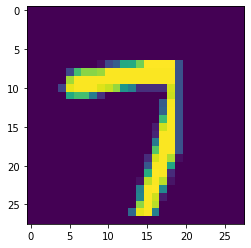

In [8]:
plt.imshow(X_train[1,:].reshape(28,28))

In [9]:
class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0)
      self.relu = nn.ReLU(inplace = True)
      self.pool1 = nn.AvgPool2d(kernel_size=2)
      self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
      self.pool2 = nn.AvgPool2d(kernel_size=2)
      self.fc1 = nn.Linear(in_features = 16*5*5, out_features = 120).cuda()
      self.fc2 = nn.Linear(in_features = 120, out_features = 90).cuda()
      self.fc3 = nn.Linear(in_features = 90,out_features = 10).cuda()
      self.do = nn.Dropout2d(0.25)

    def forward(self, x):
      x = self.conv1(x)
      x = self.relu(x)
      x = self.pool1(x)
      x = self.conv2(x)
      x = self.relu(x)
      x = self.do(x) 
      x = self.pool2(x)
      x = x.view(x.size(0), -1)
      x = self.fc1(x)
      x = self.relu(x)
      x = self.do(x)
      x = self.fc2(x)
      y = self.relu(x)
      return y
    

In [15]:
np.random.seed(1)
batch_size = 100
n_iter = int(len(X_train)/batch_size) + 1
n_epochs = 500

train = TensorDataset(X_train, Y_train)
test = TensorDataset(X_test, Y_test)

train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

model = LeNet().to(device)

loss_fn = nn.CrossEntropyLoss()

#optimizer = optim.SGD(model.parameters(), lr = 0.001)

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)




In [16]:
def accuracy(outputs, labels):
    probs = F.softmax(outputs, dim=1)
    max_probs, preds = torch.max(probs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))
    

In [ ]:
count = 0
for epoch in range(n_epochs):
    
    for i, (images, labels) in enumerate(train_loader):
    

      train = Variable(images.view(100,1,28,28)).to(device)
      labels = Variable(labels).to(device)

      optimizer.zero_grad()

      outputs = model(train)

      loss = loss_fn(outputs, labels.type(torch.LongTensor))

      loss.backward()

      optimizer.step()
    
      count += 1
    
    with torch.no_grad():
        X_test = X_test.view(12000,1,28,28)
        val_output = model(X_test)
        val_loss = loss_fn(val_output, Y_test.type(torch.LongTensor))
        val_accuracy = accuracy(val_output, Y_test)
    
    print(f"Epoch {epoch+1}: Loss = {loss}, accuracy = {accuracy(outputs, labels)}, val_loss = {val_loss}, val_acc = {val_accuracy}")
    




Epoch 1: Loss = 0.3833608627319336, accuracy = 0.8899999856948853, val_loss = 0.4519517421722412, val_acc = 0.8600833415985107
Epoch 2: Loss = 0.35257256031036377, accuracy = 0.9100000262260437, val_loss = 0.31196117401123047, val_acc = 0.9066666960716248
Epoch 3: Loss = 0.2585313022136688, accuracy = 0.9300000071525574, val_loss = 0.24457049369812012, val_acc = 0.9273333549499512
Epoch 4: Loss = 0.2008364349603653, accuracy = 0.949999988079071, val_loss = 0.2061314433813095, val_acc = 0.9351666569709778
Epoch 5: Loss = 0.17222629487514496, accuracy = 0.949999988079071, val_loss = 0.1743098497390747, val_acc = 0.9455833435058594
Epoch 6: Loss = 0.2104608416557312, accuracy = 0.9200000166893005, val_loss = 0.16375572979450226, val_acc = 0.9489166736602783
Epoch 7: Loss = 0.18668504059314728, accuracy = 0.9399999976158142, val_loss = 0.14456836879253387, val_acc = 0.9583333134651184
Epoch 8: Loss = 0.15715095400810242, accuracy = 0.9599999785423279, val_loss = 0.13897892832756042, val_ac

Epoch 65: Loss = 0.02357371151447296, accuracy = 0.9900000095367432, val_loss = 0.07978016883134842, val_acc = 0.9807500243186951
Epoch 66: Loss = 0.026066260412335396, accuracy = 0.9900000095367432, val_loss = 0.08390568941831589, val_acc = 0.9797499775886536
Epoch 67: Loss = 0.047158654779195786, accuracy = 0.9800000190734863, val_loss = 0.08221184462308884, val_acc = 0.9805833101272583
Epoch 68: Loss = 0.03431112691760063, accuracy = 0.9800000190734863, val_loss = 0.07376948744058609, val_acc = 0.9815833568572998
Epoch 69: Loss = 0.038765452802181244, accuracy = 0.9900000095367432, val_loss = 0.07956971973180771, val_acc = 0.9807500243186951
Epoch 70: Loss = 0.025506598874926567, accuracy = 0.9900000095367432, val_loss = 0.07491985708475113, val_acc = 0.9817500114440918
Epoch 71: Loss = 0.01852736435830593, accuracy = 0.9900000095367432, val_loss = 0.08026167005300522, val_acc = 0.9810000061988831
Epoch 72: Loss = 0.05239706113934517, accuracy = 0.9700000286102295, val_loss = 0.0743

Epoch 131: Loss = 0.03143944963812828, accuracy = 0.9900000095367432, val_loss = 0.07663457095623016, val_acc = 0.9825000166893005
Epoch 132: Loss = 0.046414680778980255, accuracy = 0.9900000095367432, val_loss = 0.07355044782161713, val_acc = 0.984083354473114
Epoch 133: Loss = 0.0025621599052101374, accuracy = 1.0, val_loss = 0.07591935992240906, val_acc = 0.9826666712760925
Epoch 134: Loss = 0.047384973615407944, accuracy = 0.9800000190734863, val_loss = 0.07996480166912079, val_acc = 0.9825833439826965
Epoch 135: Loss = 0.08497259020805359, accuracy = 0.9700000286102295, val_loss = 0.0774536058306694, val_acc = 0.984083354473114
Epoch 136: Loss = 0.06345690041780472, accuracy = 0.9800000190734863, val_loss = 0.09180718660354614, val_acc = 0.9829166531562805
Epoch 137: Loss = 0.056554242968559265, accuracy = 0.9800000190734863, val_loss = 0.08010812103748322, val_acc = 0.9835000038146973
Epoch 138: Loss = 0.04530855640769005, accuracy = 0.9900000095367432, val_loss = 0.0754078552126

Epoch 197: Loss = 0.009918684139847755, accuracy = 0.9900000095367432, val_loss = 0.07453470677137375, val_acc = 0.984333336353302
Epoch 198: Loss = 0.07167097181081772, accuracy = 0.9700000286102295, val_loss = 0.08457469195127487, val_acc = 0.9838333129882812
Epoch 199: Loss = 0.010788810439407825, accuracy = 1.0, val_loss = 0.07588078081607819, val_acc = 0.9850000143051147
Epoch 200: Loss = 0.0061288257129490376, accuracy = 1.0, val_loss = 0.07796331495046616, val_acc = 0.9827499985694885
Epoch 201: Loss = 0.0317293182015419, accuracy = 0.9900000095367432, val_loss = 0.08194148540496826, val_acc = 0.9839166402816772
Epoch 202: Loss = 0.05767468363046646, accuracy = 0.9900000095367432, val_loss = 0.0667496919631958, val_acc = 0.9860000014305115
Epoch 203: Loss = 0.006758010946214199, accuracy = 1.0, val_loss = 0.08395413309335709, val_acc = 0.9818333387374878
Epoch 204: Loss = 0.017120828852057457, accuracy = 0.9900000095367432, val_loss = 0.08255043625831604, val_acc = 0.98341667652

In [13]:
df = pd.read_csv('test.csv')
test_set = df.values/255

In [14]:
test_set = test_set.astype(np.float32)
x = torch.from_numpy(test_set).view(-1,1,28,28)
predictions = model(x)
probs = F.softmax(predictions, dim=1)
max_probs, preds = torch.max(probs, dim=1)
submission = pd.DataFrame({"ImageId": list(range(1, len(preds)+1)),
                          "Label": preds})
submission.to_csv("predictions.csv", index = False, header = True)